In [1]:
!pip install "line_profiler[ipython]" ipython==8.5.0 ffmpeg-python imutils==0.5.4 sahi scikit-learn supervision google-generativeai ipywidgets

In [7]:
# This experiment depends on specific files.
video_path = "/home/luis/workspace/vacocam_render/source/prerender.mp4"
detections_path = "/home/luis/workspace/vacocam_render/experiments/vacocam/2024_04_02-2_claude3_5sec/source/track/prerender_detections_declustered.npy"

In [3]:
import hashlib

md5 = hashlib.md5()

with open(video_path, "rb") as f:
    for chunk in iter(lambda: f.read(4096), b""):
        md5.update(chunk)

assert md5.hexdigest() == "6d30279ea8ab9754c748d5752d97a027", "The video file is not the correct one."

md5 = hashlib.md5()
with open(detections_path, "rb") as f:
    for chunk in iter(lambda: f.read(4096), b""):
        md5.update(chunk)

assert md5.hexdigest() == "0631148b034011bb4fd463ee9ab9323e", "The detections file is not the correct one."

print("All files are correct.")

All files are correct.


In [9]:
# set the experiment variables

seconds = 3

#### First, generate a presentation for every section in our video. This includes loading the cleaned up ball detections for the video

In [10]:
import supervision as sv
import cv2
import os

from detections import load_detections, Detections

_, detections = load_detections(detections_path)

video_info = sv.VideoInfo.from_video_path(video_path)

framerate = video_info.fps
total_frames = video_info.total_frames or 0

frame_indices = [(i * seconds * framerate, (i + 1) * seconds * framerate) for i in range(int(total_frames / (seconds * framerate)))]
if frame_indices[-1][1] != total_frames:
    frame_indices.append((frame_indices[-1][1], total_frames))

def make_video_section(cap, start, end):
    dets = detections[start:end]
    # find a frame in the middle of the section, but provided it has detections
    mid = int((start + end) / 2)

    while len(detections[mid]) == 0:
        mid += 1

    cap.set(cv2.CAP_PROP_POS_FRAMES, mid)
    ret, sample = cap.read()
    
    if not ret:
        raise Exception("Error reading video")

    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    return (dets, sample)

loaded 112300 detections from /home/luis/workspace/vacocam_render/experiments/vacocam/2024_04_02-2_claude3_5sec/source/track/prerender_detections_declustered.npy


In [12]:
# cluster detections and find overlaps

%load_ext autoreload
%autoreload 2

from tracking import cluster_detections, get_artifact_id

# for video generation
from tracking import present_section
import numpy as np
from PIL import Image
from io import BytesIO

from tqdm import tqdm

overlaps = {}

detections_sum = 0
clustered_sum = 0

cap = cv2.VideoCapture(video_path)

v_out = cv2.VideoWriter("sections.mp4", cv2.VideoWriter_fourcc(*'mp4v'), framerate, (video_info.width, video_info.height))

for start, end in tqdm(frame_indices):
    section_detections = detections[start:end]
    clustered_detections: dict[int, list[Detections]] = cluster_detections(section_detections, image_width=video_info.width, image_height=video_info.height, preset="play")

    clustered_detections_minus_noise: dict[int, list[Detections]] = { key: detections for key, detections in clustered_detections.items() if key != -1 }

    detections_sum_section = sum([len(detections) for detections in section_detections])
    clustered_sum_section = sum([len(detections) for detections_l in clustered_detections_minus_noise.values() for detections in detections_l])

    detections_sum += detections_sum_section
    clustered_sum += clustered_sum_section

    if (start > 95000 and end < 96000 + 15 * framerate) or (start > 103000 and end < 104000 + 15 * framerate):
        _section_detections, sample = make_video_section(cap, start, end)
        section_img, section_metadata = present_section(sample, clustered_detections, ignore_noise=False)
        video_frame = np.array(Image.open(BytesIO(section_img)))
        # add a label to the top left corner with the section id
        cv2.putText(video_frame, "Section {}".format(start), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        v_out.write(cv2.cvtColor(video_frame, cv2.COLOR_RGB2BGR))

    # find clusters start and ends
    start_ends: dict[int, tuple[int, int]] = { key: (0, 0) for key in clustered_detections_minus_noise.keys() }

    for key, c_detections in clustered_detections_minus_noise.items():
        # find start of the cluster, meaning the index of the first detection that is not empty. (len(detection) > 0)
        cluster_start = 0
        for i, detection in enumerate(c_detections):
            if len(detection) > 0:
                cluster_start = i
                break
        # find end of the cluster, meaning the index of the last detection that is not empty. (len(detection) > 0)
        cluster_end = 0
        for i, detection in enumerate(reversed(c_detections)):
            if len(detection) > 0:
                cluster_end = len(c_detections) - i
                break
        start_ends[key] = (cluster_start, cluster_end)
    
    # now find any overlapping clusters
    overlapping_clusters = {}

    for key1, (start1, end1) in start_ends.items():
        for key2, (start2, end2) in start_ends.items():
            if key1 != key2 and start1 < end2 and end1 > start2:
                overlap = min(end1, end2) - max(start1, start2)

                if (key1, key2) in overlapping_clusters or (key2, key1) in overlapping_clusters:
                    continue
                if overlap < min(end1 - start1, end2 - start2) * 0.5:
                    continue
                if end1 - start1 < 15 or end2 - start2 < 15 or overlap < 15:
                    continue

                overlapping_clusters[(key1, key2)] = {
                    "overlap": min(end1, end2) - max(start1, start2),
                    "clusters": {
                        key1: clustered_detections_minus_noise[key1],
                        key2: clustered_detections_minus_noise[key2]
                    },
                    "bounds": {
                        key1: (start + start1, start + end1),
                        key2: (start + start2, start + end2)
                    },
                }


    if len(overlapping_clusters) > 0:
        overlaps[(start, end)] = overlapping_clusters

v_out.release()

print("[VacomCam] Done finding overlaps")
print("[VacomCam] Found {} overlaps".format(sum([len(value) for value in overlaps.values()])))

print("[VacomCam] Total detections: {}".format(detections_sum))
print("[VacomCam] Total clustered detections: {}".format(clustered_sum))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 1248/1248 [00:16<00:00, 75.75it/s] 

[VacomCam] Done finding overlaps
[VacomCam] Found 25 overlaps
[VacomCam] Total detections: 43305
[VacomCam] Total clustered detections: 40905


In [18]:
# save presented sections to disk

%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
from io import BytesIO

from tracking import present_section, save_section_presentation

# print overlaps ordered by overlap time descendent
overlaps = { key: value for key, value in sorted(overlaps.items(), key=lambda item: sum([va["overlap"] for va in item[1].values()]), reverse=True) }

# lets also make a video of the overlaps for easier viewing
v_out = cv2.VideoWriter("overlaps.mp4", cv2.VideoWriter_fourcc(*'mp4v'), framerate, (1920, 1080))

for (section_start, section_end), overlapping_clusters in overlaps.items():
    formatted_start = f"{int(section_start / framerate / 60)}:{int(section_start / framerate % 60)}"
    formatted_end = f"{int(section_end / framerate / 60)}:{int(section_end / framerate % 60)}"

    print(f"{formatted_start} - {formatted_end}")

    for (key1, key2), overlap_data in overlapping_clusters.items():
        start1, end1 = overlap_data["bounds"][key1]
        start2, end2 = overlap_data["bounds"][key2]

        start = min(start1, start2)
        end = max(end1, end2)

        print(f"\t{key1} - {key2} ({overlap_data['overlap']} frames overlap)")
        formatted_start = f"{int(start / framerate / 60)}:{int(start / framerate % 60)}"
        formatted_end = f"{int(end / framerate / 60)}:{int(end / framerate % 60)}"
        print(f"\t\t{formatted_start} - {formatted_end}")

        artifact_id = get_artifact_id(video_path, start, end, framerate)

        _section_detections, sample = make_video_section(cap, start, end)
        section_img, section_metadata = present_section(sample, overlap_data["clusters"], version="v3")
        
        save_section_presentation(artifact_id, section_img, section_metadata)

        video_frame = np.array(Image.open(BytesIO(section_img)))
        v_out.write(cv2.cvtColor(video_frame, cv2.COLOR_RGB2BGR))

v_out.release()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
5:39 - 5:42
	0 - 1 (58 frames overlap)
		5:39 - 5:42
5:33 - 5:36
	0 - 1 (44 frames overlap)
		5:33 - 5:36
11:45 - 11:48
	0 - 1 (41 frames overlap)
		11:45 - 11:48
57:36 - 57:39
	1 - 2 (41 frames overlap)
		57:36 - 57:39
53:0 - 53:3
	0 - 1 (39 frames overlap)
		53:0 - 53:3
29:0 - 29:3
	0 - 1 (36 frames overlap)
		29:0 - 29:3
2:18 - 2:21
	1 - 2 (35 frames overlap)
		2:18 - 2:20
2:33 - 2:36
	0 - 1 (27 frames overlap)
		2:33 - 2:36
60:30 - 60:33
	0 - 1 (26 frames overlap)
		60:30 - 60:31
5:36 - 5:39
	0 - 1 (24 frames overlap)
		5:36 - 5:37
42:45 - 42:48
	0 - 1 (24 frames overlap)
		42:45 - 42:48
37:0 - 37:3
	0 - 1 (23 frames overlap)
		37:0 - 37:1
6:15 - 6:18
	1 - 3 (21 frames overlap)
		6:17 - 6:18
13:24 - 13:27
	0 - 1 (21 frames overlap)
		13:24 - 13:27
52:33 - 52:36
	0 - 1 (21 frames overlap)
		52:33 - 52:36
6:21 - 6:24
	0 - 1 (20 frames overlap)
		6:21 - 6:24
12:33 - 12:36
	0 - 1 (20 frames overlap)

#### Cleanup and setup

Now that the sections have been generated, go and manually delete the ones you dont need. (image and metadata)

Then, run the code below:

In [2]:
import os
import matplotlib.pyplot as plt
from typing import Optional

pngs = [f for f in os.listdir("./track/presentation") if f.endswith(".png")]
artifact_ids = [os.path.basename(f).replace(".png", "") for f in pngs]

if not os.path.exists("./track/ground_truth"):
    os.makedirs("./track/ground_truth")

for png in pngs:
    csv = png.replace(".png", ".csv")

    if not os.path.isfile(os.path.join("./track/ground_truth", csv)):
        open(os.path.join("./track/ground_truth", csv), "w").close()

def load_ground_truth(artifact_id) -> Optional[dict[str, bool]]:
    ## example ground truth file:
    ## A, True
    ## B, False

    output_dir = os.path.join(os.getcwd(), "track", "ground_truth")

    file_path = os.path.join(output_dir, artifact_id + ".csv")

    if os.path.exists(file_path):
        if os.path.getsize(file_path) == 0:
            return None

        with open(file_path, "r") as f:
            file_contents = f.read()
        
        res = {}

        for line in file_contents.split("\n"):
            if line.strip() != "":
                key = line.split(",")[0].strip().upper()
                value = line.split(",")[1].strip()

                res[key] = value in ["True", "true", "1", "yes", "Yes", "YES"]

        return res
    else:
        print(f"File {file_path} does not exist")
        
        return None

def get_score(ground_truth: dict[str, bool], response: dict[str, bool]) -> float:
    if len(ground_truth) == 0:
        return 0

    score = 0
    for key in ground_truth:
        if key not in response.keys():
            print(f"Key {key} not in response, skipping")
            continue

        if ground_truth[key] == response[key]:
            score += 1
    
    print(f"Expected: [{ground_truth}]")
    print(f"Received: [{response}]")
    
    return score / len(ground_truth)

def calc_scores(responses):
    ground_truths = [{}] * len(artifact_ids)
    scores = [0.0] * len(artifact_ids)

    for idx, artifact_id in enumerate(artifact_ids):
        ground_truth = load_ground_truth(artifact_id)

        if ground_truth is None:
            print(f"Ground truth for {artifact_id} does not exist, skipping")
            continue
        else:
            print(f"Loaded ground truth for {artifact_id}")

        ground_truths[idx] = ground_truth

        response = responses[idx]

        score = get_score(ground_truth, response)

        print(f"Score: {score}\n")

        scores[idx] = score

    print(f"Overall score: {sum(scores) / len(scores)}")

    # show a dot for every data point int the graph, and also a line connecting them
    # also show the id next to the dot, rotated 90 degrees
    plt.plot(scores, 'o-')

    for idx, score in enumerate(scores):
        plt.text(idx, score, artifact_ids[idx], ha='center', va='center', fontsize=8, rotation=90)

    plt.show()

#### Now, call gpt4 vision for each presented section in our dataset

In [4]:
%load_ext autoreload
%autoreload 2

import time
from tracking import load_section_presentation, load_gpt4_response, save_gpt4_response, parse_gemini_response, ask_gippity_for_primary_clusters
from tqdm import tqdm

responses = [{}] * len(artifact_ids)

for idx, artifact_id in enumerate(tqdm(artifact_ids)):
    section_img, section_metadata = load_section_presentation(artifact_id)

    if section_img is None or section_metadata is None:
        raise Exception("Error loading section presentation")

    loaded_response = load_gpt4_response(artifact_id)

    if loaded_response is not None:
        print(f"[VacomCam] Loaded response from cache ({artifact_id})")
        gpt4_response = loaded_response
    else:
        print(f"[VacomCam] Submitting section to Gemini ({artifact_id})")
        gpt4_response = ask_gippity_for_primary_clusters(section_img, section_metadata, version="v3")
    
        if gpt4_response is None:
            print("GPT-4 response was None, SAVING EMPTY RESPONSE")

        save_gpt4_response(artifact_id, gpt4_response)

    gpt4_response_parsed = parse_gemini_response(gpt4_response)

    if gpt4_response_parsed is None:
        print("Gemini response could not be parsed, skipping section")
        continue

    responses[idx] = gpt4_response_parsed

    # sleep for 15 seconds to avoid rate limiting
    # time.sleep(15)

print("[VacomCam] Done processing video sections")

100%|██████████| 25/25 [00:00<00:00, 436.53it/s]

[VacomCam] Loaded response from cache (prerender.mp4_02-12_02-14)
Parsed GPT-4 response
{'A': True, 'B': False}
[VacomCam] Loaded response from cache (prerender.mp4_05-36_05-37)
Parsed GPT-4 response
{'A': True, 'B': False}
[VacomCam] Loaded response from cache (prerender.mp4_05-42_05-42)
Parsed GPT-4 response
{'A': True, 'B': False}
[VacomCam] Loaded response from cache (prerender.mp4_06-17_06-18)
Parsed GPT-4 response
{'B': True, 'D': False}
[VacomCam] Loaded response from cache (prerender.mp4_02-18_02-20)
Parsed GPT-4 response
{'B': True, 'C': False}
[VacomCam] Loaded response from cache (prerender.mp4_13-24_13-27)
Parsed GPT-4 response
{'A': True, 'B': False}
[VacomCam] Loaded response from cache (prerender.mp4_26-27_26-29)
Parsed GPT-4 response
{'A': True, 'B': False}
[VacomCam] Loaded response from cache (prerender.mp4_17-39_17-42)
Parsed GPT-4 response
{'A': True, 'B': False}
[VacomCam] Loaded response from cache (prerender.mp4_06-21_06-24)
Parsed GPT-4 response
{'A': True, 'B':

Loaded ground truth for prerender.mp4_02-12_02-14
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_05-36_05-37
Expected: [{'B': True, 'A': False}]
Received: [{'A': True, 'B': False}]
Score: 0.0

Loaded ground truth for prerender.mp4_05-42_05-42
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_06-17_06-18
Expected: [{'B': False, 'D': False}]
Received: [{'B': True, 'D': False}]
Score: 0.5

Loaded ground truth for prerender.mp4_02-18_02-20
Expected: [{'B': True, 'C': False}]
Received: [{'B': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_13-24_13-27
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_26-27_26-29
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_17-39_17-42
Expected: [

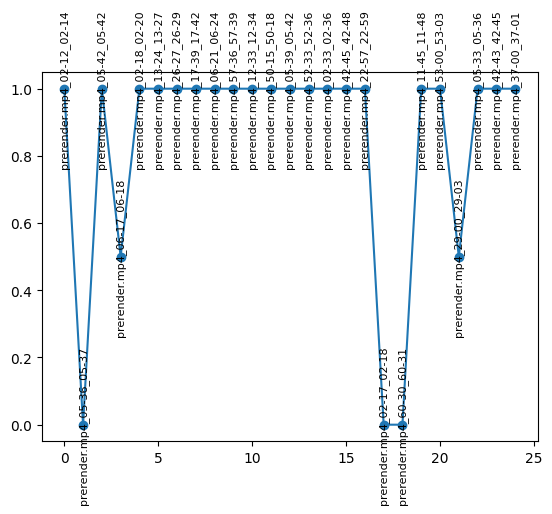

In [5]:
calc_scores(responses)